In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
#Using some tips from StackOverflow to suppress warnings
#https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import scipy.stats as st

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [11]:
# Checking what the data looks like for the measurements table
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7ff42fa3fa10>,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'prcp': 0.08}

In [12]:
# Checking what the data looks like for the stations table
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7ff42fa29890>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1}

In [13]:
# Using the inspector to print the column names within the 'measurment' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [15]:
# Perform a query to retrieve the date and precipitation scores 
last_twelve_months = session.query(Measurement.date, Measurement.prcp) \
.filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame 
precip_data_df = pd.DataFrame(last_twelve_months, columns=['date', 'precipitation'])

# Remove precipitaion scores that are NAN
precip_data_year = precip_data_df.dropna()

# Convert date column to a date type
precip_data_year.date = pd.to_datetime(precip_data_year.date)

# Set the index to the date column
precip_data_year.set_index('date', inplace=True)

# precip_data_df.dtypes
precip_data_year

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


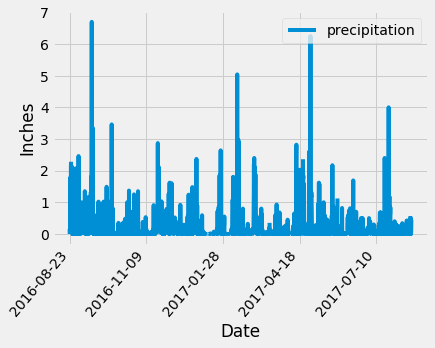

In [16]:
# Use Pandas Plotting to plot the data
precip_data_df.plot(x = "date", y = "precipitation")

# Add the axes labels
plt.xlabel("Date") 
plt.ylabel("Inches")
# Change the rotation and alignment of the dates
plt.xticks(rotation=50, ha='right')

# Put the legend in the upper right corner
plt.legend(loc=1)

plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_summary = precip_data_df.groupby("date").describe()
precip_summary

precipitation                                                   \
                   count      mean       std   min     25%    50%     75%   
date                                                                        
2016-08-23           6.0  0.451667  0.706468  0.00  0.0275  0.100  0.5625   
2016-08-24           6.0  1.555000  0.840541  0.08  1.2775  1.800  2.1500   
2016-08-25           7.0  0.077143  0.071813  0.00  0.0300  0.080  0.0950   
2016-08-26           6.0  0.016667  0.016330  0.00  0.0025  0.015  0.0275   
2016-08-27           5.0  0.064000  0.081731  0.00  0.0000  0.020  0.1200   
...                  ...       ...       ...   ...     ...    ...     ...   
2017-08-19           3.0  0.030000  0.051962  0.00  0.0000  0.000  0.0450   
2017-08-20           2.0  0.005000  0.007071  0.00  0.0025  0.005  0.0075   
2017-08-21           3.0  0.193333  0.317700  0.00  0.0100  0.020  0.2900   
2017-08-22           3.0  0.166667  0.288675  0.00  0.0000  0.000  0.2500   
2017-08-23           4.0  0.132500  0.215000  0.00  0.0000  0.040  0.1725   

                  
             max  
date              
2016-08-23  1.79  
2016-08-24  2.28  
2016-08-25  0.21  
2016-08-26  0.04  
2016-08-27  0.18  
...          ...  
2017-08-19  0.09  
2017-08-20  0.01  
2017-08-21  0.56  
2017-08-22  0.50  
2017-08-23  0.45  

[366 rows x 8 columns]

In [18]:
# Design a query to show how many stations are available in this dataset
station_count = session.query(Station.station).count()
print(f"The total number of stations is {station_count}.")

The total number of stations is 9.


In [19]:
# What are the most active stations in the complete data set? (i.e. what stations have the most rows)?

# Get all the stations and corresponding measurements using the measurement database
all_measurements = session.query(Measurement.station, Measurement.tobs).order_by(Measurement.station).all()

# Make a data frame of the station and station name
station_names = session.query(Station.id, Station.station, Station.name).order_by(Station.station).all()
station_names_df = pd.DataFrame(station_names, columns=['id','station', 'name'])

# Make a data frame of the measurements at each station
all_measurements_df = pd.DataFrame(all_measurements, columns=['station', 'tobs'])

# Merge the measurement and station data frames by station name 
all_stations = pd.merge(all_measurements_df['station'], station_names_df, on='station', how='left')
all_stations = all_stations.rename(columns={'id':'station id', 'station': 'measurements count'})

#Group by station name
active_stations = all_stations.groupby(['name', 'station id']).count()

# List the station names and id with the measurements count in descending order.
active_stations.sort_values('measurements count', ascending=False)


,,measurements count
name,station id,
"WAIHEE 837.5, HI US",7,2772
"WAIKIKI 717.2, HI US",1,2724
"KANEOHE 838.1, HI US",2,2709
"WAIMANALO EXPERIMENTAL FARM, HI US",6,2669
"MANOA LYON ARBO 785.2, HI US",9,2612
"KUALOA RANCH HEADQUARTERS 886.9, HI US",3,2202
"HONOLULU OBSERVATORY 702.2, HI US",8,1979
"PEARL CITY, HI US",4,1372
"UPPER WAHIAWA 874.3, HI US",5,511


In [88]:
# List the stations sorted from most to least active
active_stations = session.query(Station.id, Station.name, func.count(order_by(Measurement.station)).filter(Measurement.station == Station.station).group_by(Measurement.station).all()
active_stations

[(8, 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 (2, 'KANEOHE 838.1, HI US', 2709),
 (3, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 (9, 'MANOA LYON ARBO 785.2, HI US', 2612),
 (4, 'PEARL CITY, HI US', 1372),
 (5, 'UPPER WAHIAWA 874.3, HI US', 511),
 (7, 'WAIHEE 837.5, HI US', 2772),
 (1, 'WAIKIKI 717.2, HI US', 2724),
 (6, 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669)]

In [42]:
# Get a list of the station id, station, and station name
station_names = session.query(Station.id, Station.station, Station.name).order_by(Station.id).all()
station_names

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US'),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US'),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 (4, 'USC00517948', 'PEARL CITY, HI US'),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US'),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US')]

In [45]:
# Get the min, max, and avg temp (tobs) data for station 7, the most active
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)]
station_seven = session.query(*sel).filter(Measurement.station == 'USC00519281').all()

#Put the TOBS query results in a data frame
station_seven_df = pd.DataFrame(station_seven, columns=['min','max', 'avg'])
station_seven_df

,min,max,avg
0,54.0,85.0,71.663781


In [23]:
# Last 12 months of temperature observation data (TOBS) for station 7
last_year_station7 = session.query(Measurement.date, Measurement.tobs) \
.filter(Measurement.date >= '2016-08-23', Measurement.station == 'USC00519281').order_by(Measurement.date).all()

#Putting the query results in a dataframe
station7_tobs_data = pd.DataFrame(last_year_station7, columns=['date', 'tobs'])

station7_tobs_data

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


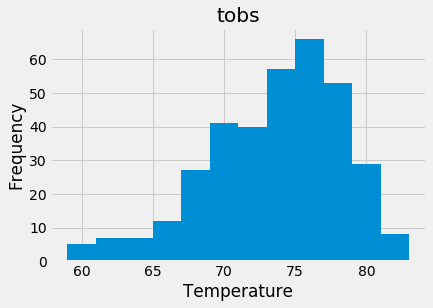

In [24]:
# Plot the results as a histogram
tobs_histogram = station7_tobs_data.hist(bins=12)

# Add the axes labels
plt.xlabel("Temperature") 
plt.ylabel("Frequency")

# Put the legend in the upper right corner
# plt.legend(loc=1)
tobs_histogram
plt.show()

## Bonus Challenge Assignment - Not Attemtempted (leaving starter code for reference)

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
